<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%2014/Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries#

In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import os

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


# Hyperparameters

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}


# Predefined Classes

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

# Import Data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

# Cutout Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from albumentations import (Compose, Cutout)

def Custom_Aug(img):
  seq = Compose([
          Cutout(num_holes=1, p=0.5)], p=1)
  return seq(image=img)['image']

train_datagen = ImageDataGenerator(preprocessing_function=Custom_Aug)

train_generator = train_datagen.flow(x_train, y_train, batch_size=50000)

x_batch, y_batch = next(train_generator)

Using TensorFlow backend.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


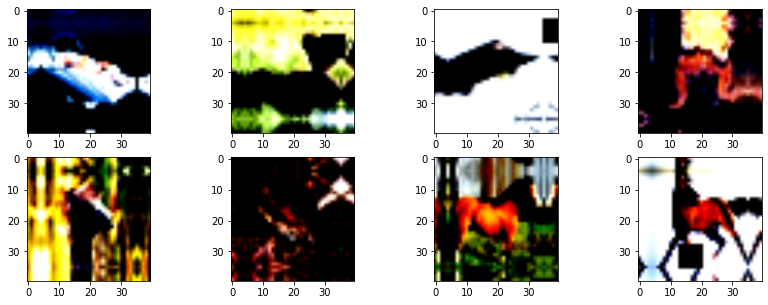

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='bilinear')

# Create TFRecord Classes

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def convert_np_to_tf_example(image, label):
    feature_dict = {
        'image': _bytes_feature(image.tostring()),
        'label': _int64_feature(label),
    }

    features = tf.train.Features(feature=feature_dict)
    tf_example = tf.train.Example(features=features)
    protocol_message = tf_example.SerializeToString()

    return protocol_message

def convert_proto_message_to_np(protocol_message):
    feature_dict = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_out = tf.io.parse_single_example(serialized=protocol_message,
                                            features=feature_dict)
    
    image = tf.io.decode_raw(parsed_out['image'], out_type=tf.float32)
    label = parsed_out['label']

    return (image,label)
    
def reshape_img(X, img_shape):
    img = X[0].numpy()
    label = X[1]
    img = img.reshape(img_shape)
    img_tensor = tf.convert_to_tensor(img)

    return (img_tensor, label)
  
def convert_np_to_tfrecords(images, labels, 
                            batch_size=128,filename=None):

    # Converts a numpy array into TFReocrds
    
    channels = images.shape[-1]
    width = images.shape[-2]
    height = images.shape[-3]

    img_shape = (height, width, channels)
    if filename == None:
        filename = 'dataset.tfrecords'
    with tf.io.TFRecordWriter(filename) as writer:
        for img,label in zip(images,labels):
            protocol_message = convert_np_to_tf_example(img,label)

            writer.write(protocol_message)
        
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(convert_proto_message_to_np)
    dataset = dataset.map(lambda x, y: (tf.reshape(x,img_shape), y))
    
    return dataset

# Model and Parameters

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

# Model Training

In [13]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

original_train_set = convert_np_to_tfrecords(x_train, y_train, batch_size=1,filename='train_set.tfrecords')
test_set = convert_np_to_tfrecords(x_test, y_test, batch_size=BATCH_SIZE, filename='test_set.tfrecords').batch(BATCH_SIZE)

list_train_acc = []
list_test_acc = []
list_train_loss = []
list_test_loss = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  
  train_set = original_train_set.map(data_aug).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  list_test_loss.append(test_loss)
  list_test_acc.append(test_acc)
  list_train_loss.append(train_loss)
  list_train_acc.append(train_acc)  

  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.5839818658447267 train acc: 0.42608 val loss: 1.2984832122802734 val acc: 0.5321 time: 60.04050898551941



epoch: 2 lr: 0.16 train loss: 0.8408386743164062 train acc: 0.7029 val loss: 0.9609833801269532 val acc: 0.6746 time: 98.3266007900238



epoch: 3 lr: 0.24 train loss: 0.6346514175415039 train acc: 0.77888 val loss: 0.771246957397461 val acc: 0.7473 time: 135.97456002235413



epoch: 4 lr: 0.32 train loss: 0.5360961926269531 train acc: 0.81742 val loss: 0.7629334625244141 val acc: 0.7487 time: 173.241370677948



epoch: 5 lr: 0.4 train loss: 0.473252109375 train acc: 0.83756 val loss: 0.6045137878417969 val acc: 0.8063 time: 211.23368310928345



epoch: 6 lr: 0.37894736842105264 train loss: 0.3867014567565918 train acc: 0.86806 val loss: 0.507390234375 val acc: 0.8417 time: 248.61470770835876



epoch: 7 lr: 0.35789473684210527 train loss: 0.3168494943237305 train acc: 0.89012 val loss: 0.5214911956787109 val acc: 0.834 time: 285.5060851573944



epoch: 8 lr: 0.33684210526315794 train loss: 0.26325731979370115 train acc: 0.90878 val loss: 0.39736343002319335 val acc: 0.8665 time: 322.6765732765198



epoch: 9 lr: 0.31578947368421056 train loss: 0.2261725894165039 train acc: 0.92258 val loss: 0.4518357879638672 val acc: 0.8449 time: 360.11914253234863



epoch: 10 lr: 0.2947368421052632 train loss: 0.20089342788696288 train acc: 0.92974 val loss: 0.3456611488342285 val acc: 0.8899 time: 398.1034941673279



epoch: 11 lr: 0.2736842105263158 train loss: 0.17327796829223632 train acc: 0.94002 val loss: 0.3815420394897461 val acc: 0.875 time: 435.5098316669464



epoch: 12 lr: 0.25263157894736843 train loss: 0.1472343820953369 train acc: 0.94852 val loss: 0.35205418548583983 val acc: 0.8914 time: 473.36190581321716



epoch: 13 lr: 0.23157894736842108 train loss: 0.1292905542373657 train acc: 0.95632 val loss: 0.2900123550415039 val acc: 0.9106 time: 511.7346782684326



epoch: 14 lr: 0.2105263157894737 train loss: 0.10881060699462891 train acc: 0.9629 val loss: 0.3050404792785645 val acc: 0.9048 time: 549.258288860321



epoch: 15 lr: 0.18947368421052635 train loss: 0.0892519786453247 train acc: 0.97 val loss: 0.29551674270629885 val acc: 0.9122 time: 586.517507314682



epoch: 16 lr: 0.16842105263157897 train loss: 0.07740562160491943 train acc: 0.9734 val loss: 0.2788160354614258 val acc: 0.9157 time: 623.2014346122742



epoch: 17 lr: 0.1473684210526316 train loss: 0.06540763530731201 train acc: 0.97876 val loss: 0.2795785037994385 val acc: 0.9163 time: 659.8693990707397



epoch: 18 lr: 0.12631578947368421 train loss: 0.05544479797363281 train acc: 0.9824 val loss: 0.29958256378173825 val acc: 0.9173 time: 697.4358732700348



epoch: 19 lr: 0.10526315789473689 train loss: 0.04610866792678833 train acc: 0.98556 val loss: 0.2701269546508789 val acc: 0.9235 time: 734.437656879425



epoch: 20 lr: 0.08421052631578951 train loss: 0.038689916954040525 train acc: 0.98834 val loss: 0.25632769470214845 val acc: 0.9261 time: 771.4691019058228



epoch: 21 lr: 0.06315789473684214 train loss: 0.031106693210601808 train acc: 0.99152 val loss: 0.25266875343322753 val acc: 0.9295 time: 808.8423902988434



epoch: 22 lr: 0.04210526315789476 train loss: 0.025154938983917238 train acc: 0.99294 val loss: 0.25683345336914065 val acc: 0.9296 time: 845.49072432518



epoch: 23 lr: 0.02105263157894738 train loss: 0.022169805870056153 train acc: 0.99448 val loss: 0.2527001480102539 val acc: 0.9314 time: 882.392322063446



epoch: 24 lr: 0.0 train loss: 0.020755425577163696 train acc: 0.99502 val loss: 0.2492657485961914 val acc: 0.9316 time: 918.912721157074


# Plotting

In [0]:
def plot_model_history(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,25), train_acc)
    axs[0].plot(range(1,25), val_acc)
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,25),(25)/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,25), train_loss)
    axs[1].plot(range(1,25), val_loss)
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,25),(25)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

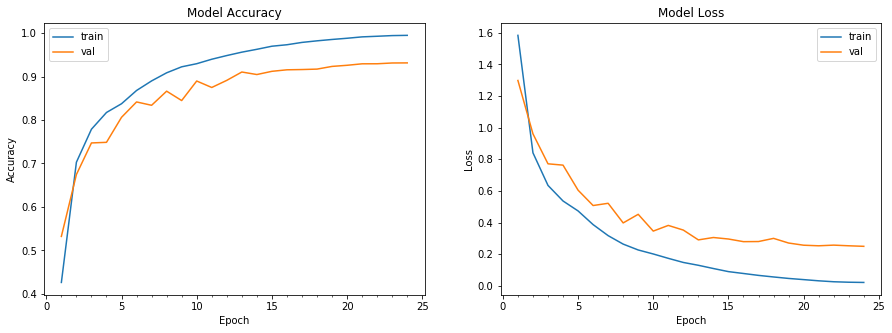

In [16]:
plot_model_history(np.asarray(list_train_acc)/len_train, np.asarray(list_test_acc)/len_test, np.asarray(list_train_loss)/len_train, np.asarray(list_test_loss)/len_test)